## Kuramoto-Sivashinsky in Python
- animation is significantly slower and more complicated
- audio via `pyo` did not work
- HTML interactive possibilies via `matplotlib` are cool

In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, ifft

import matplotlib.pyplot as plt
import matplotlib.animation as anim
plt.style.use('dark_background')

In [2]:
### example Julia code ###
def ksIntegrateJulia(u, Lx, dt, Nt, nplot):
    Nx = len(u)                  # number of gridpoints
    kx = np.concatenate((np.arange(0, Nx/2), [0.0], np.arange(-Nx/2+1, 0)))  # integer wavenumbers: exp(2*pi*i*kx*x/L)
    alpha = 2*np.pi*kx/Lx              # real wavenumbers:    exp(i*alpha*x)
    D = 1j*alpha                   # D = d/dx operator in Fourier space
    L = alpha**2 - alpha**4         # linear operator -D^2 - D^4 in Fourier space
    G = -0.5*D                      # -1/2 D operator in Fourier space
    Nplot = int(np.ceil(Nt/nplot)+1)  # total number of saved time steps
    
    x = np.arange(0, Nx)*Lx/Nx
    t = np.arange(0, Nplot)*dt*nplot
    U = np.zeros((Nplot, Nx))
    
    # some convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2
    A = np.ones(Nx) + dt2*L
    B = 1/(np.ones(Nx) - dt2*L)

    Nn  = G * fft(u*u) # -1/2 d/dx(u^2) = -u u_x, collocation calculation
    Nn1 = Nn

    U[0,:] = u # save initial value u to matrix U
    nsave = 1   # counter for saved data
    
    # transform data to spectral coeffs 
    u  = fft(u)

    # timestepping loop
    for n in range(0, Nt):
        Nn1 = Nn                       # shift N^{n-1} <- N^n
        Nn  = G * fft(np.real(ifft(u))**2) # compute N^n = -u u_x

        u = B * (A * u + dt32*Nn - dt2*Nn1); # CNAB2 formula
        
        if n % nplot == 0:
            U[nsave,:] = np.real(ifft(u))
            nsave += 1            
        
    
    return U, t, x

In [3]:
def ksIntegrateDeriv(v0, Lx, dt, Nt, nplot):
    """
    Integrates the derivative form of the Kuramoto-Sivashinsky equation
    and returns solution array v[t, x] and corresponding t and x arrays.
    """
    
    Nx = len(v0)
    kx = np.concatenate((np.arange(0, Nx/2), [0.0], np.arange(-Nx/2+1, 0)))  # integer wavenumbers with weird ordering
    alpha = 2 * np.pi / Lx * kx
    L = alpha**2 - alpha**4
    Nplot = int(np.ceil(Nt / nplot) + 1) # number of time-steps to be plotted
    
    t = np.arange(0, Nplot) * dt * nplot
    x = np.arange(0, Nx) * Lx / Nx
    V = np.zeros((Nplot, Nx))
    
    # pre-compute reused variables
    dt2 = dt / 2
    dt32 = 3 * dt / 2
    G = 0.5j * alpha # note: no minus sign!
    A = np.ones(Nx) + dt2 * L
    B = 1 / (np.ones(Nx) - dt2 * L)
    
    Nn = G * fft(v0**2)
    Nn1 = Nn
    
    V[0,:] = v0 # boundary condition v(t=0, x)
    nsave = 1 # counter for saved data
    v = fft(v0) # transform to Fourier coefficients
    
    # time-stepping
    for n in range(0, Nt):
        Nn1 = Nn
        Nn = G * fft(np.real(ifft(v))**2)
        
        v = B * (A * v + dt32 * Nn - dt2 * Nn1)
        
        if n % nplot == 0:
            V[nsave,:] = np.real(ifft(v))
            nsave += 1
    
    return V, t, x

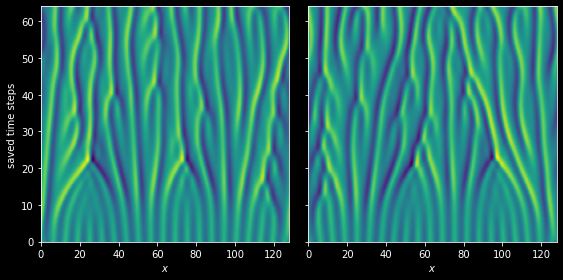

In [4]:
# test run
Lx = 128
Nx = 2048
dt = 1/32
nplot = 4
Nt = 2048

x = np.arange(0, Nx) * Lx / Nx
u0 = np.cos(x) + 0.1 * np.cos(x/16) * (1 + 2 * np.sin(x/16))
# u0 = np.sin(x/8) * np.cos(x/3) + 2*np.cos(x/16)
# u0 = np.exp(-(x - Lx/2)**2 / np.sqrt(Lx))

UJ, tJ, xJ = ksIntegrateJulia(u0, Lx, dt, Nt, nplot)
UP, tP, xP = ksIntegrateDeriv(u0, Lx, dt, Nt, nplot)

# plot test run
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].pcolormesh(xJ, tJ, UJ, shading='nearest', cmap='viridis')
# ax[0].imshow(,UJ, cmap='viridis')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('saved time steps')
ax[1].pcolormesh(xP, tP, UP, shading='nearest', cmap='viridis')
ax[1].set_xlabel(r'$x$')
fig.set_size_inches(8, 4)
fig.tight_layout()

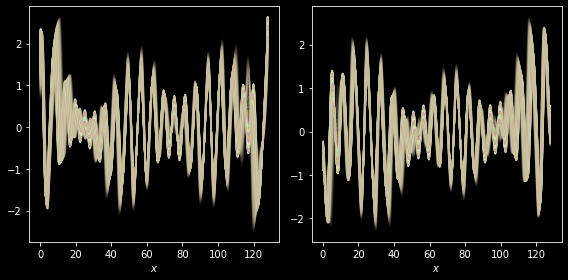

In [5]:
# transition from boundary function
start = 50
num = 50

fig, ax = plt.subplots(ncols=2)
for i in range(start, start+num):
    ax[0].plot(xJ, UJ[i,:], alpha=1.0-(i-start)/num)
    ax[1].plot(xP, UP[i,:], alpha=1.0-(i-start)/num)
ax[0].set_xlabel(r'$x$')
ax[1].set_xlabel(r'$x$')
fig.set_size_inches(8, 4)
fig.tight_layout()

### Interaction & animation
First, will try `ipywidgets` to tweak multiple parameters on the fly.

In [6]:
from ipywidgets import interact
from IPython import display

# use OS ffmpeg instead of conda installation
# since conda installation did not work...
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

In [7]:
def interactKS(Lx=128, Nx=1024, dt=1/16, nplot=4, Nt=1024, trunc=False):
    x = np.arange(0, Nx) * Lx / Nx
#     u0 = np.cos(x) + 0.1 * np.cos(x/16) * (1 + 2 * np.sin(x/16))
    u0 = 2 * np.sin(2*np.pi*x/Lx)
    U, t, x = ksIntegrateDeriv(u0, Lx, dt, Nt, nplot)
    
    if trunc is True:
        U = np.clip(U, a_min=0, a_max=np.inf)
        
    plt.pcolormesh(x, t, U, shading='nearest', cmap='magma')
    plt.xlabel(r'$x$')
    plt.ylabel('saved time steps')
    plt.tight_layout()

In [8]:
%matplotlib inline

interact(interactKS,
    Lx=[32, 64, 128, 256],
    Nx=[256, 512, 1024, 2048],
    dt=(1e-2, 0.5, 0.01),
    nplot=(1, 12),
    Nt=[256, 512, 1024, 2048, 4096],
    trunc=False)

interactive(children=(Dropdown(description='Lx', index=2, options=(32, 64, 128, 256), value=128), Dropdown(des…

<function __main__.interactKS(Lx=128, Nx=1024, dt=0.0625, nplot=4, Nt=1024, trunc=False)>

Animations can be printed to some javascript HTML format via `to_jshtml()` which brings a mini player with it. This however seems to be relatively slow compared to just plain printing to .mp4 via `ffmpeg`.

When sweeping through the time interval parameter $\Delta t$, we observe that the CNAB2 method starts to show oscillations for sufficiently large ratios of $\Delta t/\Delta x^2$.

In [9]:
# animated dt sweep
Lx = 128
Nx = 512
dt = np.arange(0.01, 0.5, 0.01)
nplot = 4
Nt = 512

fig = plt.figure(figsize=(5, 5), facecolor='black')
ax = plt.subplot(frameon=False)

x = np.arange(0, Nx) * Lx / Nx
u0 = np.cos(x) + 0.1 * np.cos(x/16) * (1 + 2 * np.sin(x/16))
    
def init():
    U, t, x = ksIntegrateDeriv(u0, Lx, dt[0], Nt, nplot)
    U = np.clip(U, a_min=0, a_max=np.inf)
    ax.pcolormesh(x, t, U, shading='nearest', cmap='magma')
    ax.set_xticks([])
    ax.set_yticks([])
    
def update(frame):
    U, t, x = ksIntegrateDeriv(u0, Lx, frame, Nt, nplot)
    U = np.clip(U, a_min=0, a_max=np.inf)
    ax.pcolormesh(x, t, U, shading='nearest', cmap='magma')
    
ani = anim.FuncAnimation(fig, update, frames=dt, init_func=init, blit=False)
plt.close()

In [10]:
html = display.HTML(ani.to_jshtml())
display.display(html)

Animations can simply be exported to .mp4 using the `matplotlib.animation.FFMpegWriter()` writer. The performance for shorter animations is okay.

In [29]:
# dt sweep
Lx = 128
Nx = 512
dt = np.arange(0.01, 0.5, 0.01)
nplot = 4
Nt = 512

fig = plt.figure(figsize=(6, 6), facecolor='black')
ax = plt.subplot(frameon=False)

x = np.arange(0, Nx) * Lx / Nx
# u0 = np.cos(x) + 0.1 * np.cos(x/16) * (1 + 2 * np.sin(x/16))
# u0 = np.sin(x/8) * np.cos(x/3) + 2*np.cos(x/16)
u0 = np.exp(-(x - Lx/2)**2 / np.sqrt(Lx))
    
def init():
    U, t, x = ksIntegrateDeriv(u0, Lx, dt[0], Nt, nplot)
    U = np.clip(U, a_min=0, a_max=np.inf)
    ax.pcolormesh(x, t, U, shading='nearest', cmap='magma')
    ax.set_xticks([])
    ax.set_yticks([])
    
def update(frame):
    U, t, x = ksIntegrateDeriv(u0, Lx, frame, Nt, nplot)
    U = np.clip(U, a_min=0, a_max=np.inf)
    ax.pcolormesh(x, t, U, shading='nearest', cmap='magma')
    
ani = anim.FuncAnimation(fig, update, frames=dt, init_func=init, blit=False)
writer = anim.FFMpegWriter(fps=10, metadata=dict(artist='pbrehmer'), bitrate=1800)
ani.save("dt_sweep_01.mp4", writer=writer)
plt.close()

A computationally cheap method to animate is to pre-compute the KS solution and then to only update plot parameters, such as `ax.set_ylim()` to sweep through the time parameter.

In [21]:
# fixed dt, sweep Nt by axis limit
Lx = 128
Nx = 2056
dt = 1/16
Nt_init = 256 # inital number of time steps
Nt = 5012
Nplot_init = int(np.ceil(Nt_init / nplot) + 1) # initial number of time steps to be plotted
nplot = 4
anim_stepsize = 16

# plot parameters
fig = plt.figure(figsize=(6, 6), facecolor='black')
ax = plt.subplot(frameon=False)
cmap = 'magma'
shading = 'nearest'

x = np.arange(0, Nx) * Lx / Nx
# u0 = np.cos(x) + 0.1 * np.cos(x/16) * (1 + 2 * np.sin(x/16))
# u0 = np.sin(x/8) * np.cos(x/3) + 2*np.cos(x/16)
u0 = np.exp(-(x - Lx/2)**2 / np.sqrt(Lx))
U, t, x = ksIntegrateDeriv(u0, Lx, dt, Nt, nplot)
U = np.clip(U, a_min=0, a_max=np.inf)

print('Finished KS integration.')

def init():
    ax.pcolormesh(x, t, U, shading=shading, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(t[0], t[Nplot_init])
    
def update(frame):
    ax.set_ylim(t[0], t[Nplot_init + frame * int(anim_stepsize / nplot)])
    
ani = anim.FuncAnimation(fig, update, frames=int((Nt - Nt_init)/anim_stepsize), init_func=init, blit=False)
writer = anim.FFMpegWriter(fps=25, metadata=dict(artist='pbrehmer'), bitrate=1800)
ani.save("Nt_sweep_03.mp4", writer=writer)
plt.close()

Finished KS integration.


In [21]:
# live time-stepping
%matplotlib qt

# plot parameters
fig = plt.figure(figsize=(4, 4), facecolor='black')
ax = plt.subplot(frameon=False)
cmap = 'magma'
shading = 'nearest'

# KS parameters
Lx = 256
Nx = 512
dt = 1/16
nplot = 4
anim_stepsize = 4
Nt = 512 # number of time steps within figure
Nplot = int(np.ceil(Nt / nplot) + 1) # number of time steps within figure

x = np.arange(0, Nx) * Lx / Nx
t = np.arange(0, Nplot) * dt * nplot
U = np.zeros((Nplot, Nx))
u0 = np.cos(x) + 0.1 * np.cos(x/16) * (1 + 2 * np.sin(x/16))
# u0 = np.sin(2*np.pi*x/Lx) * np.cos(x/3) + 2*np.cos(x/16)
# u0 = np.exp(-(x - Lx/2)**2 / np.sqrt(Lx))
# u0 = np.random.uniform(-1, 1, size=Nx)

# pre-compute reused variables
# kx = [0, Nx] provides a stable evolution of u0, whereas
# kx = [0:Nx/2, 0, -Nx/2+:0] ends up at a diverging solution
kx = np.arange(0, Nx) # integer wavenumber with apparently false ordering
# kx = np.concatenate((np.arange(0, Nx/2), [0.0], np.arange(-Nx/2+1, 0)))  # integer wavenumbers with weird ordering
alpha = 2 * np.pi / Lx * kx
L = alpha**2 - alpha**4
dt2 = dt / 2
dt32 = 3 * dt / 2
G = 0.5j * alpha
A = np.ones(Nx) + dt2 * L
B = 1 / (np.ones(Nx) - dt2 * L)
    
# initialize plot and KS data
Nn = G * fft(u0**2)
Nn1 = Nn
U[0,:] = u0 
U_clipped = np.clip(U, a_min=0, a_max=np.inf)
u = fft(u0)
nsave = 1

for n in range(0, Nt):
    Nn1 = Nn
    Nn = G * fft(np.real(ifft(u))**2)
    u = B * (A * u + dt32 * Nn - dt2 * Nn1)

    if n % nplot == 0:
        U[nsave,:] = np.real(ifft(u))
        nsave += 1

U_clipped = np.clip(U, a_min=0, a_max=np.inf)
quad_mesh = ax.pcolormesh(x, t, U_clipped, shading=shading, cmap=cmap)
fig.colorbar(quad_mesh, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
print('Finished initialization.')

# update and animate
def update(frame):
    global Nn, u, nsave, U, t
    # time steps per updated frame
    for n in range(0, anim_stepsize):
        Nn1 = Nn
        Nn = G * fft(np.real(ifft(u))**2)
        u = B * (A * u + dt32 * Nn - dt2 * Nn1)
        
        if n % nplot == 0:
            U = np.concatenate((U[1:,:], np.real(ifft(u))[np.newaxis,:]), axis=0)
            U_clipped = np.clip(U, a_min=0, a_max=np.inf)
            t = np.concatenate((t[1:], [nsave * dt * nplot]))
            nsave += 1
            
    quad_mesh.set_array(U.flatten()) # update color mesh data
    return quad_mesh,
    
ani = anim.FuncAnimation(fig, update, interval=20, blit=True)
plt.show()

Finished initialization.
